In [2]:
import numpy as np
import pandas as pd
import pickle as pkl

%run utils/utils_keras.py

Using TensorFlow backend.


In [34]:
import tensorflow as tf

from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import AveragePooling2D
from keras.layers import Concatenate
from keras.layers import Lambda
from keras import optimizers
from keras import metrics

from time import time
from tensorflow.python.keras.callbacks import TensorBoard

In [3]:
file_indices = [i + (616 if i>260 else 0) for i in range(696)][:100]
n_files = len(file_indices)
print('Number of chunks =',n_files)

Number of chunks = 100


#### Load data at once (only for limited dataset)

In [4]:
data = pd.DataFrame()
for chunk_id in file_indices:
    data = data.append(pkl.load(open('../data/processed_chunks/processed_ttd_chunk_{}.p'.format(chunk_id), 'rb')))

#data.drop(data[data.vec_dist > 15].index, inplace=True)

# Drop trips with distance exceeding 40 miles
data.drop(data[data.trip_dist > 40].index, inplace=True)

In [5]:
# This guarantees indices to be unique, which is important for random permutation
data.reset_index(drop=True, inplace=True)

In [6]:
n_samples = len(data)
train_p = 0.7
valid_p = 0.2

In [7]:
# # Square box around NYC
LAT_NORTH = 40.976897
LAT_SOUTH = 40.418079
LON_EAST = -73.700272
LON_WEST = -74.259090
assert LAT_NORTH-LAT_SOUTH == LON_EAST-LON_WEST
RANGE = LAT_NORTH-LAT_SOUTH
RANGE

0.5588180000000023

In [8]:
step = 5*1e-4
data['pu_lon_n_q'] = data.pu_lon_n.apply(lambda x: np.floor(x/step))
data['pu_lat_n_q'] = data.pu_lat_n.apply(lambda x: np.floor(x/step))
data['do_lon_n_q'] = data.do_lon_n.apply(lambda x: np.floor(x/step))
data['do_lat_n_q'] = data.do_lat_n.apply(lambda x: np.floor(x/step))

1/(5*1e-4)

In [12]:
# Idea of treating input as image

# def get_gaussian(gauss_kernel = 5):
#     x, y = np.meshgrid(np.linspace(-1,1,gauss_kernel), np.linspace(-1,1,gauss_kernel))
#     d = np.sqrt(x*x+y*y)
#     sigma, mu = 1.0, 0.0
#     return np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
    
# g = get_gaussian()
# print(g)

# N_SAMPLES = 400#len(data)//10000 #100
# image_data = np.zeros((N_SAMPLES,2000,2000,1))

# for index, row in data[:N_SAMPLES].iterrows():
#     image_array = np.zeros((2000,2000))

#     pu_lat = int(row.pu_lat_n_q)
#     pu_lon = int(row.pu_lon_n_q)
#     do_lat = int(row.do_lat_n_q)
#     do_lon = int(row.do_lon_n_q)
        
#     gauss_kernel = g.shape[0]
#     image_data[index, pu_lon-gauss_kernel//2:pu_lon+gauss_kernel//2+1, pu_lat-gauss_kernel//2:pu_lat+gauss_kernel//2+1, 0] = g    
#     image_data[index, do_lon-gauss_kernel//2:do_lon+gauss_kernel//2+1, do_lat-gauss_kernel//2:do_lat+gauss_kernel//2+1, 0] = -g    \

# plt.figure(figsize=(16,16))
# plt.imshow(image_data[10,:,:,0],cmap='gray')
# #plt.xlim((1000,1250))
# #plt.ylim((900,1000))

In [16]:
# min_pu_lon_n = 0.42
# max_pu_lon_n = 0.47

# min_pu_lat_n = 0.58
# max_pu_lat_n = 0.60

# block_data = data[(data.pu_lon_n < max_pu_lon_n) & 
#                   (data.pu_lon_n > min_pu_lon_n) &
#                   (data.pu_lat_n < max_pu_lat_n) &
#                   (data.pu_lat_n > min_pu_lat_n)]
# #block_data = data

# step = 5*1e-4
# block_data_pu_lon_n = block_data.pu_lon_n.apply(lambda x: np.floor(x/step)*step)
# block_data_pu_lat_n = block_data.pu_lat_n.apply(lambda x: np.floor(x/step)*step)

# #long_trips = block_data[block_data.vec_dist > 15]
# #np.floor(data.pu_lon_n/step)*step


# plt.figure(figsize=(12,12))
# plt.scatter(block_data.pu_lon_n[:100000],block_data.pu_lat_n[:100000],s=1)
# plt.scatter(block_data_pu_lon_n[:100000],block_data_pu_lat_n[:100000],s=1,c='r')


# # for i in range(0,len(long_trips),1):
# #     #if long_trips.iloc[i].original_index != 5173594:
# #     #    continue
# # #        print('OPA')
# #     plt.plot((long_trips.iloc[i].pu_lon_n, long_trips.iloc[i].do_lon_n),
# #              (long_trips.iloc[i].pu_lat_n, long_trips.iloc[i].do_lat_n))
# #     plt.scatter(long_trips.iloc[i].pu_lon_n, long_trips.iloc[i].pu_lat_n,s=50, c='k')
# #     plt.scatter(long_trips.iloc[i].do_lon_n, long_trips.iloc[i].do_lat_n,s=50, c='r')

# #plt.scatter(data.pu_lon_n[:400000],data.pu_lat_n[:400000],s=1)
# plt.xlim((0.45,0.47))
# plt.ylim((0.58,0.6))

# #plt.xlim((min_pu_lon_n,max_pu_lon_n))
# #plt.ylim((min_pu_lat_n,max_pu_lat_n))

### Split samples (save and/or load)

In [17]:
# train_samples_ids, valid_samples_ids, test_samples_ids = np.split(np.random.permutation(data.index),
#                                                                   [int(n_samples*(train_p)),
#                                                                    int(n_samples*(train_p + valid_p))])

#samples_ids = {'train_samples_ids':train_samples_ids, 'valid_samples_ids':valid_samples_ids, 'test_samples_ids':test_samples_ids}
#np.save('samples_split_ids.npy', samples_ids)
#samples_ids_check = np.load('samples_split_ids.npy')[()]

#assert np.all(samples_ids['train_samples_ids'] == samples_ids_check['train_samples_ids'])
#assert np.all(samples_ids['valid_samples_ids'] == samples_ids_check['valid_samples_ids'])
#assert np.all(samples_ids['test_samples_ids'] == samples_ids_check['test_samples_ids'])

In [19]:
samples_ids = np.load('samples_split_ids.npy')[()]
train_samples_ids = samples_ids['train_samples_ids']
valid_samples_ids = samples_ids['valid_samples_ids']
test_samples_ids = samples_ids['test_samples_ids']

In [21]:
# plt.figure(figsize=(12,6))
# plt.subplot(211)
# plt.hist(data.duration, bins='auto', log=True)
# plt.xlim(0,7300)
# plt.subplot(212)
# plt.hist(data.trip_dist, bins='auto', log=True)
# plt.xlim(0,45)
# plt.show()

# print('Normalized plots')
# plt.figure(figsize=(12,6))
# plt.subplot(211)
# plt.hist(data.duration/MAX_DURATION, bins='auto', log=True)
# plt.xlim(0,1)
# plt.subplot(212)
# plt.hist(data.trip_dist/MAX_DISTANCE, bins='auto', log=True)
# plt.xlim(0,1)
# plt.show()

#### Normalize outputs

In [22]:
MAX_DURATION = 7200
MAX_DISTANCE = 40

data['trip_dist_norm'] = data.trip_dist/MAX_DISTANCE
data['duration_norm'] = data.duration/MAX_DURATION

#### Feature encoding

In [23]:
# Encoding time with sin/cos
data['avg_hour_sin'] = np.sin(data.avg_hour * 2 * np.pi/ 24)
data['avg_hour_cos'] = np.cos(data.avg_hour * 2 * np.pi/ 24)
data['week_day_sin'] = np.sin(data.week_day * 2 * np.pi/ 24)
data['week_day_cos'] = np.cos(data.week_day * 2 * np.pi/ 24)

# Encoding time categorically
# data[['avg_hour_cat_' + str(i) for i in range(24)]] = pd.DataFrame(to_categorical(data.avg_hour)).astype('int')
# data[['week_day_cat_' + str(i) for i in  range(7)]] = pd.DataFrame(to_categorical(data.week_day)).astype('int')

# Defining features accordingly
FEATS = ['pu_lon_n', 'pu_lat_n', 'do_lon_n', 'do_lat_n', 'vec_dist']
[FEATS.append(i) for i in ['avg_hour_sin', 'avg_hour_cos', 'week_day_sin', 'week_day_cos']]    #Sine/cosine
#[FEATS.append('week_day_cat_' + str(i)) for i in  range(7)];                                   #Categorical (weekday)
#[FEATS.append('avg_hour_cat_' + str(i)) for i in range(24)];                                   #Categorical (avghour)

TARGET = ['duration_norm', 'trip_dist_norm'] # 2 tasks (normalized)
N_FEATS = len(FEATS)

train_data = data.iloc[train_samples_ids]
valid_data = data.iloc[valid_samples_ids]
test_data  = data.iloc[test_samples_ids]

print('Number of samples for training   =', len(train_data))
print('Number of samples for validation =', len(valid_data))
print('Number of samples for testing    =', len(test_data))

train_input, train_output = np.array(train_data[FEATS]), np.array(train_data[TARGET])
valid_input, valid_output = np.array(valid_data[FEATS]), np.array(valid_data[TARGET])
test_input,  test_output  = np.array( test_data[FEATS]), np.array( test_data[TARGET])

Number of samples for training   = 6806066
Number of samples for validation = 1944590
Number of samples for testing    = 972296


In [24]:
data.head()

,original_index,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,fare_amount,tip_amount,...,pu_lon_n_q,pu_lat_n_q,do_lon_n_q,do_lat_n_q,trip_dist_norm,duration_norm,avg_hour_sin,avg_hour_cos,week_day_sin,week_day_cos
0,0,2016-04-16 15:32:19,2016-04-16 15:48:38,1.66,-73.989342,40.734261,-73.973190,40.749870,11.5,1.00,...,965.0,1131.0,1023.0,1187.0,0.0415,0.135972,-0.707107,-0.707107,0.965926,2.588190e-01
1,1,2016-04-23 22:55:51,2016-04-23 23:04:15,3.00,-73.967606,40.762981,-73.939804,40.798103,10.5,0.00,...,1043.0,1234.0,1142.0,1360.0,0.0750,0.070000,-0.258819,0.965926,0.965926,2.588190e-01
2,2,2016-04-03 01:18:07,2016-04-03 01:29:10,4.24,-73.968681,40.754639,-73.994118,40.709721,13.5,0.00,...,1039.0,1204.0,948.0,1043.0,0.1060,0.092083,0.258819,0.965926,1.000000,6.123234e-17
3,3,2016-04-27 15:16:36,2016-04-27 15:19:59,0.64,-73.963608,40.777000,-73.972328,40.782280,4.5,0.00,...,1057.0,1284.0,1026.0,1303.0,0.0160,0.028194,-0.707107,-0.707107,0.500000,8.660254e-01
4,4,2016-04-26 07:33:33,2016-04-26 07:57:27,5.90,-73.965652,40.754841,-73.990768,40.745171,21.5,4.46,...,1050.0,1205.0,960.0,1170.0,0.1475,0.199167,0.965926,-0.258819,0.258819,9.659258e-01


In [26]:
def mae_func(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred))
def mape_func(y_true, y_pred):
    return 100*np.mean(np.abs((y_true-y_pred)/y_true))
def mare_func(y_true, y_pred):
    return 100*np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

In [27]:
from sklearn import linear_model

# Create linear regression object
lin_reg = linear_model.LinearRegression()
lin_reg.fit(np.vstack((train_input,  valid_input)),
            np.vstack((train_output,valid_output))[:,0:1])

lin_reg_pred = lin_reg.predict(test_input)

print('MAE  =',mae_func(test_output[:,0:1], lin_reg_pred))
print('MAPE =',mape_func(test_output[:,0:1], lin_reg_pred))
print('MARE =',mare_func(test_output[:,0:1], lin_reg_pred))

MAE  = 0.03888184363905187
MAPE = 50.05643085480839
MARE = 32.066189931672724


In [18]:
from sklearn import linear_model

# Create linear regression object
lin_reg = linear_model.LinearRegression()
lin_reg.fit(np.vstack((train_input,  valid_input)),
            np.vstack((train_output,valid_output))[:,0:1])

lin_reg_pred = lin_reg.predict(test_input)

print('MAE  =',mae_func(test_output[:,0:1], lin_reg_pred))
print('MAPE =',mape_func(test_output[:,0:1], lin_reg_pred))
print('MARE =',mare_func(test_output[:,0:1], lin_reg_pred))

MAE  = 0.0385784803344784
MAPE = 49.80183056579425
MARE = 31.81600361249874


### Load chunks for each partition

In [ ]:
# train_p = 0.7
# valid_p = 0.2

# train_chunks_ids, valid_chunks_ids, test_chunks_ids = np.split(np.random.permutation(file_indices),
#                                                                [int(n_files*(train_p)),
#                                                                 int(n_files*(train_p + valid_p))])
# print('Number of chunks for training   =', len(train_chunks_ids))
# print('Number of chunks for validation =', len(valid_chunks_ids))
# print('Number of chunks for testing    =', len(test_chunks_ids))

# for chunk_id in train_chunks_ids:
#     train_data = train_data.append(pkl.load(open('../data/processed_chunks/processed_ttd_chunk_{}.p'.format(chunk_id), 'rb')))
# for chunk_id in valid_chunks_ids:
#     valid_data = valid_data.append(pkl.load(open('../data/processed_chunks/processed_ttd_chunk_{}.p'.format(chunk_id), 'rb')))
# for chunk_id in test_chunks_ids:
#     test_data = test_data.append(pkl.load(open('../data/processed_chunks/processed_ttd_chunk_{}.p'.format(chunk_id), 'rb')))
      
# print('Number of trips for training =', len(train_data))
# print('Number of trips for validation =', len(valid_data))
# print('Number of trips for testing =', len(test_data))

# FEATS = ['pu_lon_n', 'pu_lat_n', 'do_lon_n', 'do_lat_n', 'vec_dist', 'avg_hour', 'week_day']
# TARGET = ['duration']

# train_input, train_output = np.array(train_data[FEATS]), np.array(train_data[TARGET])
# valid_input, valid_output = np.array(valid_data[FEATS]), np.array(valid_data[TARGET])
# test_input,  test_output  = np.array( test_data[FEATS]), np.array( test_data[TARGET])

#### Generator

In [ ]:
# # This generator will:
# # 1) Randomly pick a chunk (which has around 100k trips)
# # 2) Explore that chunk, until it visits about 50% of it
# # 3) Move to another chunk and do the same
# #
# # Visitation percentage can be increased. There is a chance of returning to that same chunk in the future

# def data_generator(chunk_ids, batch_size):
    
#     # A value of -1 indicates no chunk has been read
#     chunk_id = -1
#     n_samples_left = 0
    
#     while True:
        
#         if chunk_id == -1 or n_samples_left < batch_size:
#             # Randomly pick a chunk
#             chunk_id = np.random.choice(chunk_ids)            
#             chunk = pkl.load(open('../data/processed_chunks/processed_ttd_chunk_{}.p'.format(chunk_id), 'rb'))            
#             n_samples_left = len(chunk)
        
#         # Sample batch
#         batch = chunk.sample(n=batch_size)
#         batch_input  = batch[['pu_lon_n', 'pu_lat_n', 'do_lon_n', 'do_lat_n', 'vec_dist', 'avg_hour', 'week_day']]
#         batch_output = batch[['duration']]
        
#         # Drop batch from chunk (avoid repeating samples next time)
#         chunk.drop(batch.index, inplace=True)
        
#         n_samples_left = len(chunk)
        
#         # Return a tuple of (input,output) to feed the network
#         batch_x = np.array( batch_input )
#         batch_y = np.array( batch_output )
        
#         # Comment this before using
#         yield( batch_x, batch_y )

In [ ]:
# print("[INFO] training w/ generator...")

# #NUM_TRAIN_IMAGES // BS,
# #NUM_TEST_IMAGES // BS,

# STEPS_PER_EPOCH_TRAIN = 0.7*650*100000 // BATCH_SIZE
# STEPS_PER_EPOCH_VALID = 0.2*650*100000 // BATCH_SIZE

# H = model.fit_generator(generator=train_generator,
#                         steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
#                         epochs=NUM_EPOCHS,
#                         validation_data=valid_generator,
#                         validation_steps=STEPS_PER_EPOCH_VALID,
#                     )

# train_generator = data_generator(train_chunks_ids, batch_size=BATCH_SIZE)
# valid_generator = data_generator(valid_chunks_ids, batch_size=BATCH_SIZE)

#### Model

In [ ]:
def build_conv_model():
    
    input_layer = Input(shape=(2000,2000,1,))
 
    conv = Conv2D(25, (3,3), padding='valid', activation='relu', name = 'conv1')(input_layer)
    conv = Conv2D(25, (3,3), padding='valid', activation='relu', name = 'conv2')(conv)
    conv = Conv2D(50, (5,5), padding='valid', activation='relu', name = 'conv3')(conv)
    
    conv = Conv2D(50, (5,5), padding='valid', activation='relu', name = 'conv4')(conv)
    pool = AveragePooling2D(pool_size=(4,4), name = 'pool1')(conv)
    
    conv = Conv2D(50, (5,5), padding='valid', activation='relu', name = 'conv5')(pool)
    pool = AveragePooling2D(pool_size=(4,4), name = 'pool2')(conv)
    
    conv = Conv2D(50, (5,5), padding='valid', activation='relu', name = 'conv6')(pool)
    pool = AveragePooling2D(pool_size=(4,4), name = 'pool3')(conv)
    
    conv = Conv2D(50, (5,5), padding='valid', activation='relu', name = 'conv7')(pool)
    pool = AveragePooling2D(pool_size=(4,4), name = 'pool4')(conv)
    
    flat = Flatten()(pool)

    dense = Dense(100, name = 'dense1', activation  = 'relu')(flat)
    dense = Dense( 40, name = 'dense2', activation  = 'relu')(dense)
    dense = Dense(  1, name = 'output')(dense)    

    model = Model(inputs=input_layer, outputs=dense)

    opt = optimizers.Adam(lr=0.001)
    
    model.compile(loss='mse',
                  optimizer=opt,
                  metrics=[mape, mae, mare])
    return model

conv_model = build_conv_model()
conv_model.summary()

In [40]:
def build_model(alpha = 0):
    
    input_layer = Input(shape=(N_FEATS,))
    
    hidden_layer = Dense(100, name = 'shared_dense1', activation  = 'relu'))(input_layer)
    hidden_layer = Dense(100, name = 'shared_dense2', activation  = 'relu')(hidden_layer)
    hidden_layer = Dense(200, name = 'shared_dense3', activation  = 'relu')(hidden_layer)
    hidden_layer = Dense(300, name = 'shared_dense4', activation  = 'relu')(hidden_layer)
    
    # Task 1
#    hidden1_layer = Dense(300, name = 't1_dense1', activation  = 'relu')(hidden_layer) # NEW LAYER NEW
#    hidden1_layer = Dense(200, name = 't1_dense2', activation  = 'relu')(hidden_layer) # NEW LAYER
    hidden1_layer = Dense(100, name = 't1_dense3', activation  = 'relu')(hidden_layer)
    hidden1_layer = Dense( 40, name = 't1_dense4', activation  = 'relu')(hidden1_layer)
    output1_layer = Dense(  1, name = 'duration')(hidden1_layer)
    
#    # Task 2
#     hidden2_layer = Dense(100, name = 't2_dense1', activation  = 'relu')(hidden_layer)
#     hidden2_layer = Dense( 40, name = 't2_dense2', activation  = 'relu')(hidden2_layer)
#     output2_layer = Dense(  1, name = 'distance')(hidden2_layer)
#
#     model = Model(inputs=input_layer, outputs=[output1_layer, output2_layer])

    model = Model(inputs=input_layer, outputs=output1_layer)

    opt = optimizers.Adam(lr=0.001)
    
#     LOSS_WEIGHTS = [1,      # MAIN TASK
#                     alpha]  # AUXILIARY TASK

#     model.compile(loss=['mse', 'mse'],
#                   optimizer=opt,
#                   metrics=[mape, mae, mare],
#                   loss_weights=LOSS_WEIGHTS)
    
    model.compile(loss=huber_loss,
                  optimizer=opt,
                  metrics=[mape, mae, mare])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
shared_dense1 (Dense)        (None, 100)               1000      
_________________________________________________________________
shared_dense2 (Dense)        (None, 100)               10100     
_________________________________________________________________
shared_dense3 (Dense)        (None, 200)               20200     
_________________________________________________________________
shared_dense4 (Dense)        (None, 300)               60300     
_________________________________________________________________
t1_dense3 (Dense)            (None, 100)               30100     
_________________________________________________________________
t1_dense4 (Dense)            (None, 40)                4040      
__________

14


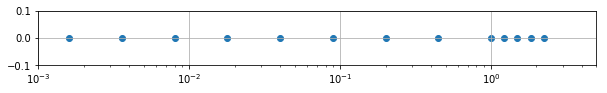

In [4]:
base = 5
test_pts = [0,
            base**-4,
            base**-3.5,
            base**-3, 
            base**-2.5, 
            base**-2, 
            base**-1.5,
            base**-1,
            base**-.5,
            base**0,
            base**0.125,
            base**0.250,
            base**0.375,
            base**0.500]

ALPHA_VALUES = test_pts

print(len(test_pts))
plt.figure(figsize=(10,1))
plt.scatter(test_pts, np.zeros(len(test_pts)))
plt.ylim((-.1,.1))
plt.xlim((1e-3,5))
plt.xscale('log')
plt.grid()
plt.show()

In [ ]:
BATCH_SIZE = 1024
NUM_EPOCHS = 75 #100

for a in ALPHA_VALUES:
    
    model = build_model(alpha=a)

    #model.metrics_names = [rename_metric_name(x) for x in model.metrics_names]    
    
    print('Training with alpha =', a)
    
    time_stamp = time()
    print('Time stamp:', time_stamp)

    tensorboard = TensorBoard(log_dir='tb_logs_norm_coord_downsamp_balanced/{}'.format(time_stamp))

    model.fit(x=train_input,
              y=[train_output[:,0], train_output[:,1]],
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(valid_input, [valid_output[:,0], valid_output[:,1]]),
              callbacks=[tensorboard])
    
    # Save model
    model_json = model.to_json()
    with open("../keras_models_norm/model_{}.json".format(time_stamp), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("../keras_models_norm/model_{}.h5".format(time_stamp))
    print("Model saved to disk.")
    
    # EVALUATION ON TEST DATA
    score = model.evaluate(test_input, [test_output[:,0],test_output[:,1]], batch_size=BATCH_SIZE)

    # Two tasks
    print('[global_loss, loss, loss_aux_distance] =', end='\n\t')
    print(score[:3])
    print('[mape, mae, mare] =', end='\n\t')
    print(score[3:6])
    print('[mape_aux_distance, mae_aux_distance, mare_aux_distance] =', end='\n\t')
    print(score[6:])

In [ ]:
# RENAME FOR MULTI-TASK (facilitate visualization on tensorboard)
def rename_metric_name(x):
    return 'global_loss' if x == 'loss' else x[1+x.find('_'):] + ('_aux_distance' if 'distance' in x else '')
model.metrics_names = [rename_metric_name(x) for x in model.metrics_names]

In [41]:
BATCH_SIZE = 1024
NUM_EPOCHS = 100

time_stamp = time()
print('Time stamp:', time_stamp)

tensorboard = TensorBoard(log_dir='tb_logs/{}'.format(time_stamp))

# model.fit(x=train_input,
#           y=[train_output[:,0], train_output[:,1]],
#           batch_size=BATCH_SIZE,
#           epochs=NUM_EPOCHS,
#           validation_data=(valid_input, [valid_output[:,0], valid_output[:,1]]),
#           callbacks=[tensorboard])

model.fit(x=train_input,
          y=train_output[:,0],
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          validation_data=(valid_input,valid_output[:,0]),
          callbacks=[tensorboard])

Time stamp: 1554861033.7310662
Train on 6806066 samples, validate on 1944590 samples
Epoch 1/100
6806066/6806066 [==============================] - 33s 5us/step - loss: 0.0011 - mape: 35.1836 - mae: 0.0312 - mare: 25.7265 - val_loss: 9.8301e-04 - val_mape: 32.3171 - val_mae: 0.0289 - val_mare: 23.7874
Epoch 2/100
6806066/6806066 [==============================] - 33s 5us/step - loss: 9.1672e-04 - mape: 30.9196 - mae: 0.0278 - mare: 22.9431 - val_loss: 8.8675e-04 - val_mape: 29.2647 - val_mae: 0.0271 - val_mare: 22.3173
Epoch 3/100
6806066/6806066 [==============================] - 33s 5us/step - loss: 8.6769e-04 - mape: 29.5690 - mae: 0.0269 - mare: 22.1392 - val_loss: 8.5130e-04 - val_mape: 29.5695 - val_mae: 0.0266 - val_mare: 21.8806
Epoch 4/100
6806066/6806066 [==============================] - 33s 5us/step - loss: 8.4790e-04 - mape: 29.0172 - mae: 0.0265 - mare: 21.8090 - val_loss: 8.4218e-04 - val_mape: 29.9654 - val_mae: 0.0264 - val_mare: 21.7826
Epoch 5/100
6806066/6806066 [==

Epoch 74/100
6806066/6806066 [==============================] - 31s 5us/step - loss: 7.5316e-04 - mape: 26.1885 - mae: 0.0245 - mare: 20.2322 - val_loss: 7.6998e-04 - val_mape: 25.2357 - val_mae: 0.0243 - val_mare: 20.0381
Epoch 75/100
6806066/6806066 [==============================] - 31s 5us/step - loss: 7.5314e-04 - mape: 26.1842 - mae: 0.0245 - mare: 20.2291 - val_loss: 7.7509e-04 - val_mape: 28.6754 - val_mae: 0.0257 - val_mare: 21.1529
Epoch 76/100
6806066/6806066 [==============================] - 33s 5us/step - loss: 7.5326e-04 - mape: 26.1774 - mae: 0.0245 - mare: 20.2318 - val_loss: 7.6885e-04 - val_mape: 27.0286 - val_mae: 0.0248 - val_mare: 20.4511
Epoch 77/100
6806066/6806066 [==============================] - 33s 5us/step - loss: 7.5229e-04 - mape: 26.1544 - mae: 0.0245 - mare: 20.2152 - val_loss: 7.6419e-04 - val_mape: 27.5290 - val_mae: 0.0251 - val_mare: 20.6936
Epoch 78/100
6806066/6806066 [==============================] - 33s 5us/step - loss: 7.5244e-04 - mape: 26.1

In [ ]:
# Save model
model_json = model.to_json()
with open("../keras_models/model_{}.json".format(time_stamp), "w") as json_file:
    json_file.write(model_json)
model.save_weights("../keras_models/model_{}.h5".format(time_stamp))
print("Model saved to disk.")

In [ ]:
# EVALUATION ON TEST DATA
#score = model.evaluate(test_input, test_output[:,0], batch_size=BATCH_SIZE)

score = model.evaluate(test_input, [test_output[:,0],test_output[:,1]], batch_size=BATCH_SIZE)

# Single task
#print('[LOSS, MAPE, MAE, MARE] =', score)

# Two tasks
print('[global_loss, loss, loss_aux_distance] =', end='\n\t')
print(score[:3])
print('[mape, mae, mare] =', end='\n\t')
print(score[3:6])
print('[mape_aux_distance, mae_aux_distance, mare_aux_distance] =', end='\n\t')
print(score[6:])

In [ ]:
pkl.dump(test_input, open('test_input.dat', 'wb'))
pkl.dump(test_output, open('test_output.dat', 'wb'))

### DISTANCE MODEL

In [61]:
def build_distance_model(alpha = 0):
    
    input_layer = Input(shape=(4,), name = 'input')
    
    hidden_layer = Dense(20, name = 'shared_dense1', activation  = 'relu')(input_layer)
    hidden_layer = Dense(100, name = 'shared_dense2', activation  = 'relu')(hidden_layer)
    hidden_layer = Dense(20, name = 'shared_dense3', activation  = 'relu')(hidden_layer)

    output_layer = Dense(1, name = 'distance')(hidden_layer)

    model = Model(inputs=input_layer, outputs=output_layer)

    opt = optimizers.Adam(lr=0.001)
    
    model.compile(loss=huber_loss,
                  optimizer=opt,
                  metrics=[mape, mae, mare])
    return model

dist_dnn_model = build_distance_model()
print(dist_dnn_model.summary())

BATCH_SIZE = 1024
NUM_EPOCHS = 100

time_stamp = time()
print('Time stamp:', time_stamp)

tensorboard = TensorBoard(log_dir='tb_logs/dist_dnn_{}'.format(time_stamp))

dist_dnn_model.fit(x=train_input[:,:4],
          y=train_output[:,1],
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          validation_data=(valid_input[:,:4],valid_output[:,1]),
          callbacks=[tensorboard])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4)                 0         
_________________________________________________________________
shared_dense1 (Dense)        (None, 20)                100       
_________________________________________________________________
shared_dense2 (Dense)        (None, 100)               2100      
_________________________________________________________________
shared_dense3 (Dense)        (None, 20)                2020      
_________________________________________________________________
distance (Dense)             (None, 1)                 21        
Total params: 4,241
Trainable params: 4,241
Non-trainable params: 0
_________________________________________________________________
None
Time stamp: 1554907706.8622103
Train on 6806066 samples, validate on 1944590 samples
Epoch 1/100
6806066/6806066 [=====================

6806066/6806066 [==============================] - 22s 3us/step - loss: 1.2482e-04 - mape: 14.6494 - mae: 0.0074 - mare: 9.8236 - val_loss: 1.2346e-04 - val_mape: 12.9687 - val_mae: 0.0072 - val_mare: 9.5865
Epoch 34/100
6806066/6806066 [==============================] - 22s 3us/step - loss: 1.2463e-04 - mape: 14.5533 - mae: 0.0074 - mare: 9.8035 - val_loss: 1.2335e-04 - val_mape: 18.2832 - val_mae: 0.0081 - val_mare: 10.6624
Epoch 35/100
6806066/6806066 [==============================] - 22s 3us/step - loss: 1.2444e-04 - mape: 14.5524 - mae: 0.0074 - mare: 9.8021 - val_loss: 1.2618e-04 - val_mape: 19.9461 - val_mae: 0.0085 - val_mare: 11.2332
Epoch 36/100
6806066/6806066 [==============================] - 22s 3us/step - loss: 1.2433e-04 - mape: 14.4586 - mae: 0.0074 - mare: 9.7903 - val_loss: 1.2245e-04 - val_mape: 12.6038 - val_mae: 0.0070 - val_mare: 9.2984
Epoch 37/100
6806066/6806066 [==============================] - 22s 3us/step - loss: 1.2423e-04 - mape: 14.4469 - mae: 0.0074 -

In [62]:
# Save model
model_json = dist_dnn_model.to_json()
with open("../keras_models/dist_dnn_model_{}.json".format(time_stamp), "w") as json_file:
    json_file.write(model_json)
dist_dnn_model.save_weights("../keras_models/dist_dnn_model_{}.h5".format(time_stamp))
print("Model saved to disk.")

Model saved to disk.


In [64]:
score = dist_dnn_model.evaluate(test_input[:,:4], test_output[:,1], batch_size=BATCH_SIZE)
print('[LOSS, MAPE, MAE, MARE] =', score)

972296/972296 [==============================] - 1s 1us/step
[LOSS, MAPE, MAE, MARE] = [0.00012102204146875933, 12.70515461608001, 0.0069249589306288415, 9.186677569990383]


### DURATION MODEL

In [69]:
from keras.models import Model

model = ...  # include here your original model

layer_name = 'shared_dense3'
intermediate_layer_model = Model(inputs=dist_dnn_model.input,
                                 outputs=dist_dnn_model.get_layer(layer_name).output)

In [75]:
dist_last_hidden_train = intermediate_layer_model.predict(train_input[:,:4])
dist_last_hidden_valid = intermediate_layer_model.predict(valid_input[:,:4])
dist_last_hidden_test = intermediate_layer_model.predict(test_input[:,:4])

In [24]:
from sklearn.externals import joblib
#filename = 'finalized_model.sav'
#joblib.dump(model, filename)

In [110]:
joblib.dump(dist_last_hidden_train, open('dist_last_hidden_train.dat', 'wb'))
joblib.dump(dist_last_hidden_valid, open('dist_last_hidden_valid.dat', 'wb'))
joblib.dump(dist_last_hidden_test, open('dist_last_hidden_test.dat', 'wb'))

In [25]:
dist_last_hidden_train = joblib.load('dist_last_hidden_train.dat')
dist_last_hidden_valid = joblib.load('dist_last_hidden_valid.dat')
dist_last_hidden_test = joblib.load('dist_last_hidden_test.dat')

In [26]:
dist_last_hidden_train.shape

(6806066, 20)

In [27]:
concatenated_train = np.hstack((dist_last_hidden_train[:], train_input[:][:,5:]))

In [28]:
concatenated_valid = np.hstack((dist_last_hidden_valid[:], valid_input[:][:,5:]))
concatenated_test  = np.hstack((dist_last_hidden_test[:], test_input[:][:,5:]))

In [29]:
concatenated_test.shape

(972296, 24)

In [31]:
def build_duration_model(alpha = 0):
    
    input_layer = Input(shape=(24,), name = 'input')
    
    hidden_layer = Dense(20, name = 'shared_dense1', activation  = 'relu')(input_layer)
    hidden_layer = Dense(100, name = 'shared_dense2', activation  = 'relu')(hidden_layer)
    hidden_layer = Dense(20, name = 'shared_dense3', activation  = 'relu')(hidden_layer)

    output_layer = Dense(1, name = 'duration')(hidden_layer)

    model = Model(inputs=input_layer, outputs=output_layer)

    opt = optimizers.Adam(lr=0.001)
    
    model.compile(loss=huber_loss,
                  optimizer=opt,
                  metrics=[mape, mae, mare])
    return model

dur_dnn_model = build_duration_model()
print(dur_dnn_model.summary())

BATCH_SIZE = 1024
NUM_EPOCHS = 100

time_stamp = time()
print('Time stamp:', time_stamp)

tensorboard = TensorBoard(log_dir='tb_logs/dur_dnn_{}'.format(time_stamp))

dur_dnn_model.fit(x=concatenated_train,
          y=train_output[:,0],
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          validation_data=(concatenated_valid,valid_output[:,0]),
          callbacks=[tensorboard])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
shared_dense1 (Dense)        (None, 20)                500       
_________________________________________________________________
shared_dense2 (Dense)        (None, 100)               2100      
_________________________________________________________________
shared_dense3 (Dense)        (None, 20)                2020      
_________________________________________________________________
duration (Dense)             (None, 1)                 21        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________
None
Time stamp: 155

Epoch 67/100
6806066/6806066 [==============================] - 21s 3us/step - loss: 8.2127e-04 - mape: 28.2986 - mae: 0.0260 - mare: 21.4068 - val_loss: 8.3088e-04 - val_mape: 31.9472 - val_mae: 0.0270 - val_mare: 22.2696
Epoch 68/100
6806066/6806066 [==============================] - 21s 3us/step - loss: 8.2125e-04 - mape: 28.2904 - mae: 0.0260 - mare: 21.4076 - val_loss: 8.2496e-04 - val_mape: 28.1090 - val_mae: 0.0257 - val_mare: 21.1848
Epoch 69/100
6806066/6806066 [==============================] - 22s 3us/step - loss: 8.2117e-04 - mape: 28.3034 - mae: 0.0260 - mare: 21.4058 - val_loss: 8.2145e-04 - val_mape: 30.1455 - val_mae: 0.0265 - val_mare: 21.8224
Epoch 70/100
6806066/6806066 [==============================] - 22s 3us/step - loss: 8.2070e-04 - mape: 28.2853 - mae: 0.0260 - mare: 21.3984 - val_loss: 8.2130e-04 - val_mape: 27.1480 - val_mae: 0.0256 - val_mare: 21.0737
Epoch 71/100
6806066/6806066 [==============================] - 21s 3us/step - loss: 8.2094e-04 - mape: 28.2

In [32]:
# Save model
model_json = dur_dnn_model.to_json()
with open("../keras_models/dur_dnn_model_{}.json".format(time_stamp), "w") as json_file:
    json_file.write(model_json)
dur_dnn_model.save_weights("../keras_models/dur_dnn_model_{}.h5".format(time_stamp))
print("Model saved to disk.")

Model saved to disk.


In [33]:
score = dur_dnn_model.evaluate(concatenated_test, test_output[:,0], batch_size=BATCH_SIZE)
print('[LOSS, MAPE, MAE, MARE] =', score)

972296/972296 [==============================] - 1s 1us/step
[LOSS, MAPE, MAE, MARE] = [0.0008172396679645793, 28.353376294969085, 0.025961281781165593, 21.413368870746552]


### DISTANCE & DURATION MODEL

In [47]:
def build_dist_dur_model(alpha = 0):
    
    input_layer = Input(shape=(8,), name = 'input')
    
    group1_spatial  = Lambda(lambda x: x[:,:4], output_shape=((4,)))(input_layer)
    group2_temporal = Lambda(lambda x: x[:,4:8], output_shape=((4,)))(input_layer)
    
    # DIST MODULE
    hidden_layer = Dense(20, name = 'shared_dense1', activation  = 'relu')(group1_spatial)
    hidden_layer = Dense(100, name = 'shared_dense2', activation  = 'relu')(hidden_layer)
    hidden_layer = Dense(20, name = 'shared_dense3', activation  = 'relu')(hidden_layer)
    output_dist_layer = Dense(1, name = 'distance')(hidden_layer)

    # CONCATENATE HIDDEN_LAYER TO GROUP2
    dur_module_input = Concatenate(name='dur_input')([hidden_layer,group2_temporal]) # Should have 24 for shape
     
    hidden_layer1 = Dense(20, name = 'shared1_dense1', activation  = 'relu')(dur_module_input)
    hidden_layer1 = Dense(100, name = 'shared1_dense2', activation  = 'relu')(hidden_layer1)
    hidden_layer1 = Dense(20, name = 'shared1_dense3', activation  = 'relu')(hidden_layer1)
    output_dur_layer = Dense(1, name = 'duration')(hidden_layer1)

    model = Model(inputs=input_layer, outputs=[output_dur_layer,output_dist_layer])

    opt = optimizers.Adam(lr=0.001)
    
    LOSS_WEIGHTS = [1, 1]

    model.compile(loss=['mse', 'mse'],
                  optimizer=opt,
                  metrics=[mape, mae, mare],
                  loss_weights=LOSS_WEIGHTS)
    return model

dist_dur_dnn_model = build_dist_dur_model()
print(dist_dur_dnn_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 8)            0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 4)            0           input[0][0]                      
__________________________________________________________________________________________________
shared_dense1 (Dense)           (None, 20)           100         lambda_7[0][0]                   
__________________________________________________________________________________________________
shared_dense2 (Dense)           (None, 100)          2100        shared_dense1[0][0]              
__________________________________________________________________________________________________
shared_den

In [48]:
BATCH_SIZE = 1024
NUM_EPOCHS = 100

time_stamp = time()
print('Time stamp:', time_stamp)

tensorboard = TensorBoard(log_dir='tb_logs/dur_dist_dnn_{}'.format(time_stamp))

COLS = [0,1,2,3,5,6,7,8]

dist_dur_dnn_model.fit(x=train_input[:,COLS],
                       y=[train_output[:,0], train_output[:,1]],
                       batch_size=BATCH_SIZE,
                       epochs=NUM_EPOCHS,
                       validation_data=(valid_input[:,COLS], [valid_output[:,0], valid_output[:,1]]),
                       callbacks=[tensorboard])

# model.fit(x=train_input,
#           y=train_output[:,0],
#           batch_size=BATCH_SIZE,
#           epochs=NUM_EPOCHS,
#           validation_data=(valid_input,valid_output[:,0]),
#           callbacks=[tensorboard])

Time stamp: 1554915233.296323
Instructions for updating:
Use tf.cast instead.
Train on 6806066 samples, validate on 1944590 samples
Epoch 1/100
6806066/6806066 [==============================] - 39s 6us/step - loss: 0.0027 - duration_loss: 0.0023 - distance_loss: 4.6126e-04 - duration_mape: 37.6894 - duration_mae: 0.0317 - duration_mare: 26.1405 - distance_mape: 24.4263 - distance_mae: 0.0109 - distance_mare: 14.4701 - val_loss: 0.0023 - val_duration_loss: 0.0020 - val_distance_loss: 3.3190e-04 - val_duration_mape: 30.2751 - val_duration_mae: 0.0284 - val_duration_mare: 23.3878 - val_distance_mape: 16.6947 - val_distance_mae: 0.0090 - val_distance_mare: 11.9320
Epoch 2/100
6806066/6806066 [==============================] - 38s 6us/step - loss: 0.0023 - duration_loss: 0.0019 - distance_loss: 3.2460e-04 - duration_mape: 33.0732 - duration_mae: 0.0289 - duration_mare: 23.8192 - distance_mape: 19.3588 - distance_mae: 0.0094 - distance_mare: 12.4568 - val_loss: 0.0022 - val_duration_loss: 0

Epoch 16/100
6806066/6806066 [==============================] - 38s 6us/step - loss: 0.0020 - duration_loss: 0.0017 - distance_loss: 2.7581e-04 - duration_mape: 29.2425 - duration_mae: 0.0265 - duration_mare: 21.8314 - distance_mape: 15.9724 - distance_mae: 0.0081 - distance_mare: 10.7641 - val_loss: 0.0019 - val_duration_loss: 0.0017 - val_distance_loss: 2.7102e-04 - val_duration_mape: 28.2805 - val_duration_mae: 0.0261 - val_duration_mare: 21.4939 - val_distance_mape: 13.9064 - val_distance_mae: 0.0078 - val_distance_mare: 10.2690
Epoch 17/100
6806066/6806066 [==============================] - 38s 6us/step - loss: 0.0020 - duration_loss: 0.0017 - distance_loss: 2.7496e-04 - duration_mape: 29.2145 - duration_mae: 0.0265 - duration_mare: 21.8040 - distance_mape: 15.9401 - distance_mae: 0.0081 - distance_mare: 10.7415 - val_loss: 0.0020 - val_duration_loss: 0.0017 - val_distance_loss: 2.6996e-04 - val_duration_mape: 28.9494 - val_duration_mae: 0.0263 - val_duration_mare: 21.6606 - val_d

6806066/6806066 [==============================] - 38s 6us/step - loss: 0.0019 - duration_loss: 0.0016 - distance_loss: 2.6283e-04 - duration_mape: 28.3133 - duration_mae: 0.0259 - duration_mare: 21.3520 - distance_mape: 15.1930 - distance_mae: 0.0078 - distance_mare: 10.3386 - val_loss: 0.0019 - val_duration_loss: 0.0016 - val_distance_loss: 2.5687e-04 - val_duration_mape: 28.0752 - val_duration_mae: 0.0258 - val_duration_mare: 21.2815 - val_distance_mape: 14.0740 - val_distance_mae: 0.0075 - val_distance_mare: 9.9919
Epoch 47/100
6806066/6806066 [==============================] - 38s 6us/step - loss: 0.0019 - duration_loss: 0.0016 - distance_loss: 2.6220e-04 - duration_mape: 28.2810 - duration_mae: 0.0259 - duration_mare: 21.3370 - distance_mape: 15.1330 - distance_mae: 0.0078 - distance_mare: 10.3133 - val_loss: 0.0019 - val_duration_loss: 0.0016 - val_distance_loss: 2.5825e-04 - val_duration_mape: 27.2826 - val_duration_mae: 0.0256 - val_duration_mare: 21.1173 - val_distance_mape: 

6806066/6806066 [==============================] - 42s 6us/step - loss: 0.0019 - duration_loss: 0.0016 - distance_loss: 2.5879e-04 - duration_mape: 28.0257 - duration_mae: 0.0257 - duration_mare: 21.2082 - distance_mape: 15.1207 - distance_mae: 0.0077 - distance_mare: 10.2425 - val_loss: 0.0019 - val_duration_loss: 0.0016 - val_distance_loss: 2.5878e-04 - val_duration_mape: 28.6735 - val_duration_mae: 0.0259 - val_duration_mare: 21.3053 - val_distance_mape: 14.7423 - val_distance_mae: 0.0078 - val_distance_mare: 10.3570
Epoch 77/100
6806066/6806066 [==============================] - 41s 6us/step - loss: 0.0019 - duration_loss: 0.0016 - distance_loss: 2.5886e-04 - duration_mape: 28.0106 - duration_mae: 0.0257 - duration_mare: 21.1991 - distance_mape: 15.1193 - distance_mae: 0.0077 - distance_mare: 10.2446 - val_loss: 0.0019 - val_duration_loss: 0.0016 - val_distance_loss: 2.5974e-04 - val_duration_mape: 28.4445 - val_duration_mae: 0.0259 - val_duration_mare: 21.3210 - val_distance_mape:

In [49]:
# Save model
model_json = dist_dur_dnn_model.to_json()
with open("../keras_models/dist_dur_dnn_model_{}.json".format(time_stamp), "w") as json_file:
    json_file.write(model_json)
dist_dur_dnn_model.save_weights("../keras_models/dist_dur_dnn_model_{}.h5".format(time_stamp))
print("Model saved to disk.")

Model saved to disk.


In [52]:
# EVALUATION ON TEST DATA
#score = model.evaluate(test_input, test_output[:,0], batch_size=BATCH_SIZE)

score = dist_dur_dnn_model.evaluate(test_input[:,COLS], [test_output[:,0],test_output[:,1]], batch_size=BATCH_SIZE)

# Single task
#print('[LOSS, MAPE, MAE, MARE] =', score)

# Two tasks
print('[global_loss, loss, loss_aux_distance] =', end='\n\t')
print(score[:3])
print('[mape, mae, mare] =', end='\n\t')
print(score[3:6])
print('[mape_aux_distance, mae_aux_distance, mare_aux_distance] =', end='\n\t')
print(score[6:])

972296/972296 [==============================] - 2s 2us/step
[global_loss, loss, loss_aux_distance] =
	[0.0018564019432673138, 0.001596615743068656, 0.00025978620108731143]
[mape, mae, mare] =
	[27.85478061452957, 0.025526032139172202, 21.05401049996036]
[mape_aux_distance, mae_aux_distance, mare_aux_distance] =
	[13.769162840300085, 0.00745008761960985, 9.882768488209251]


In [ ]:
def build_multitask_model(alpha = 0):
    
    input_layer = Input(shape=(N_FEATS,))
    
    hidden_layer = Dense(100, name = 'shared_dense1', activation  = 'relu'))(input_layer)
    hidden_layer = Dense(100, name = 'shared_dense2', activation  = 'relu')(hidden_layer)
    hidden_layer = Dense(200, name = 'shared_dense3', activation  = 'relu')(hidden_layer)
    hidden_layer = Dense(300, name = 'shared_dense4', activation  = 'relu')(hidden_layer)
    
    # Task 1
#    hidden1_layer = Dense(300, name = 't1_dense1', activation  = 'relu')(hidden_layer) # NEW LAYER NEW
#    hidden1_layer = Dense(200, name = 't1_dense2', activation  = 'relu')(hidden_layer) # NEW LAYER
    hidden1_layer = Dense(100, name = 't1_dense3', activation  = 'relu')(hidden_layer)
    hidden1_layer = Dense( 40, name = 't1_dense4', activation  = 'relu')(hidden1_layer)
    output1_layer = Dense(  1, name = 'duration')(hidden1_layer)
    
#    # Task 2
#     hidden2_layer = Dense(100, name = 't2_dense1', activation  = 'relu')(hidden_layer)
#     hidden2_layer = Dense( 40, name = 't2_dense2', activation  = 'relu')(hidden2_layer)
#     output2_layer = Dense(  1, name = 'distance')(hidden2_layer)
#
#     model = Model(inputs=input_layer, outputs=[output1_layer, output2_layer])

    model = Model(inputs=input_layer, outputs=output1_layer)

    opt = optimizers.Adam(lr=0.001)
    
#     LOSS_WEIGHTS = [1,      # MAIN TASK
#                     alpha]  # AUXILIARY TASK

#     model.compile(loss=['mse', 'mse'],
#                   optimizer=opt,
#                   metrics=[mape, mae, mare],
#                   loss_weights=LOSS_WEIGHTS)
    
    model.compile(loss=huber_loss,
                  optimizer=opt,
                  metrics=[mape, mae, mare])
    return model

model = build_model()
model.summary()